$$
D(\omega_{choose}, k_{find})=0
$$

Find $k$

We know polarisation is in $E_x$ and $E_y=E_z=0$.
$$
\vec{\vec{D}}(\omega, k)\cdot \vec E=\vec0
$$
Find the nullspace of $\vec{\vec{D}}(\omega, k)$ gives you $\vec E$ and hence relative amplitudes of the components of the electric field.

For the extraordinary mode
$$
n^2=\frac{\epsilon_\bot^2-g^2}{\epsilon_\bot}\\
E_x\propto i g\\
E_y\propto -\epsilon_\bot
$$
where $n=kc/\omega$
$$
\epsilon_\bot = 1- \sum_s \frac{\Pi_s^2}{\omega^2 - \Omega_s^2},\\
g = -\sum_s \frac{\Pi_s^2\Omega_s}{\omega (\omega^2 - \Omega_s^2)}
$$
Hence find $k_\alpha$ and $k_\beta$ associated with $\omega_\alpha$ and $\omega_\beta = \omega_\alpha + \Omega_i$ respectively. 

Choose $\omega_\alpha=\omega_L+ \Delta\omega$ where $\Delta \omega$ is a tuning parameter to find the right mode and to fix the wavenumber at something sensible. $\omega_L\approx \sqrt{\frac{\Omega_e^2}{4}+\Pi_e^2} - \frac{\Omega_e}{2}$.

Now the other parameters:

Faraday's
$$
-i\omega\vec B_1 = - \vec k \times \vec E_1
$$
Gauss's law
$$
i\vec k \cdot \vec E_1 =  \sum_s\frac{q_s n_{s,1}}{\epsilon_0}\\
$$
Ampere's law:
$$
\mu_0 \vec J = i \vec k \times \vec {B}_1 + i \omega \mu_0 \epsilon_0 \vec E_1\\
\sum_s q_s n_{s,0} \vec {v}_{s,1} = \frac{i \vec k \times \vec {B}_1}{\mu_0} + i \omega \epsilon_0 \vec E_1\\
$$
Assume the ions are unperturbed in the initial conditions
$$
q_e n_{e,0} {v}_{e,1,y} = i  \omega \epsilon_0 E_{1,x}\\
q_e n_{e,0} {v}_{e,1,y} = -\frac{i k {B}_{1,z}}{\mu_0} + i \omega \epsilon_0 E_{1,y}\\
q_e n_{e,0} {v}_{e,1,z} = \frac{i k {B}_{1,y}}{\mu_0} + i \omega \epsilon_0 E_{1,z}\\
$$

$$
n_{e,1} = i k E_{x,1}\frac{\epsilon_0}{q_s}
$$


In [55]:
using Roots, LinearAlgebra, Plots
using IntervalArithmetic, IntervalRootFinding
using NelderMead

const c = 2.99792458e8
const ϵ₀ = 8.854187817e-12
const μ₀ = 1.25663706144e-6
const q₀ = 1.602176487e-19
const mₑ = 9.10938188e-31
const n0 = 1e19
const B0 = 2.0
fΠ(n) = √(q₀^2 * n / mₑ / ϵ₀)
const Π = fΠ(n0)
const Ω = -q₀ * B0 / mₑ
fωL(n) = sqrt(Ω^2 / 4 + fΠ(n)^2) - abs(Ω) / 2
const ωL = fωL(n0)
fωₕ(n) = √(fΠ(n)^2 + Ω^2)
const ωₕ = √(fΠ(n0)^2 + Ω^2)
const Te_eV = 10e3
const vth = sqrt(2 * 10e3 * q₀ / mₑ)
fλD(n) = vth / fΠ(n)
const λD = fλD(n0)
const bulkenergy = B0^2 / 2μ₀ + n0 * mₑ * vth^2 / 2
g(ω) = Π^2 * Ω / ω / (ω^2 - Ω^2)
ϵ⊥(ω) = 1 - Π^2 / (ω^2 - Ω^2)
g(ω, n) = fΠ(n)^2 * Ω / ω / (ω^2 - Ω^2)
ϵ⊥(ω, n) = 1 - fΠ(n)^2 / (ω^2 - Ω^2)
Dxwave(ω, k, n=n0) = ϵ⊥(ω, n) * ((c*k/ω)^2 - ϵ⊥(ω, n)) + g(ω, n)^2
Dxwaveguess(ω, n=n0) = (ω / c) * (1 - fΠ(n0)^2 / ω^2 * (ω^2 - fΠ(n0)^2) / (ω^2 - fωₕ(n)^2))
kguess(ω) = ω / c * √(1 - Π^2 / ω^2 / (1 + Ω / ω))
fEx(ω) = im * g(ω)
fEy(ω) = -ϵ⊥(ω)
fE(ω, k=0) = [fEx(ω), fEy(ω), 0]
fB(ω, k) = im * cross([k, 0, 0], fE(ω)) /  ω
fJ(ω, k) = im * cross([k, 0, 0], fB(ω, k)) / μ₀ + im * ω * ϵ₀ * fE(ω)
fV(ω, k) = - fJ(ω, k) / q₀ / n0
fn(ω, k) = - im * k * fEx(ω) * ϵ₀ / q₀

fn (generic function with 1 method)

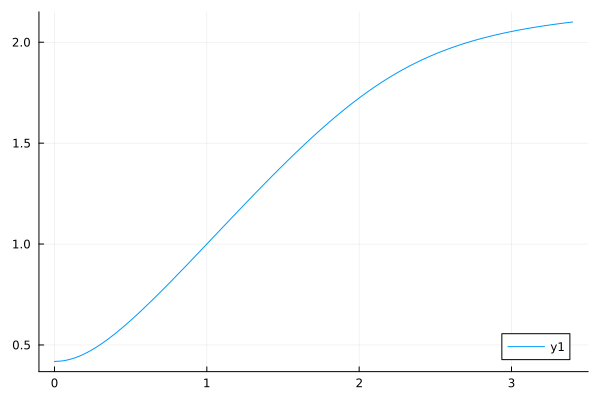

In [13]:
ωs = range(ωL, stop=0.95ωₕ, length=1024);
ks = [try;Roots.fzero(k->Dxwave(ω, k), abs(Ω)/c);catch;missing;end for ω in ωs];
# ksrts = [try;roots(k->Dxwave(ω, k), (0 .. 10) .* abs(Ω)/c)[1];catch;missing;end for ω in ωs];
# ks = [try;mid(interval(i));catch;missing;end for i in ksrts]
# ks = [Dxwaveguess(ω) for ω in ωs];
plot(ks .* c / Π, ωs ./ Π)

In [163]:
function findω(k)
  return Roots.fzero(ω->Dxwave(ω, k), (ωL + ωₕ)/2)
end
function findk(ω)
  return Roots.fzero(k->Dxwave(ω, k), fΠ(1e19) / c)
end
Lx = 8 * 1024 * λD
Kl = 2π / Lx

ωmid = (fωL(n0) + fωₕ(n0))/2
# k0 = findk(fωL(n0) * 1.3)
k0 = findk(ωmid)
nka = 64
ka = nka * Kl
function findn(n1)
  ωa = Roots.fzero(ω->Dxwave(ω, ka, n1[1] * n0), ωmid)
  ωtarget = ωa + abs(Ω) / 1836
  kb = Roots.fzero(k->Dxwave(ωtarget, k, n1[1] * n0), ka)
  nkb = nka + (kb - ka) / Kl
#    ωb = Roots.fzero(ω->Dxwave(ω, kb, n1[1] * n0), ωmid)
#   @show nka, nkb, (ωb - ωtarget) / Π
  return abs(nkb - nka - 1)
end

n01 = Roots.fzero(findn, 1) * n0
ωa = Roots.fzero(ω->Dxwave(ω, nka * Kl, n01), ωmid)
ωb = Roots.fzero(ω->Dxwave(ω, (nka + 1) * Kl, n01), ωmid)
ka = Roots.fzero(k->Dxwave(ωa, k, n01), nka * Kl)
kb = Roots.fzero(k->Dxwave(ωb, k, n01), nka * Kl)
ωb = Roots.fzero(ω->Dxwave(ω, (nka + 1) * Kl, n01), ωmid)
@assert Roots.fzero(k->Dxwave(ωa, k, n01), ka * 1.2) ≈ ka

@show (ωb - ωa) / (abs(Ω) / 1836)
@show ka / Kl, kb / Kl
@show ωa / Π, ωb / Π
@show n01


(ωb - ωa) / (abs(Ω) / 1836) = 1.0000000000002192
(ka / Kl, kb / Kl) = (64.0, 65.00000000000007)
(ωa / Π, ωb / Π) = (0.715101835588405, 0.7161757934202614)
n01 = 1.8033764596360024e19


1.8033764596360024e19

In [160]:
function findpolarisation(k)
  ω = findω(k)
  Ep = fE(ω)
  Bp = fB(ω, k)
  Vp = fV(ω, k)
  np = fn(ω, k)
 return (E=Ep, B=Bp, v=Vp, n=np)
end
pa = findpolarisation(ka)
pb = findpolarisation(kb)


(E = ComplexF64[0.0 + 1.126140442275136im, -1.27330248825258 + 0.0im, 0.0 + 0.0im], B = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, -0.0 - 2.236650941069506e-9im], v = ComplexF64[0.5312921543347966 - 0.0im, 0.16658929470825706 + 0.6007204756245584im, -0.0 - 0.0im], n = 9.332543585982897e9 + 0.0im)

In [161]:
function scale(polarisation, factor)
  return NamedTuple(k=>factor * v for (k, v) in pairs(polarisation))
end
function energy(polarisation)
  E = polarisation[:E]
  B = polarisation[:B]
  v = polarisation[:v]
  return ϵ₀ * sum(abs,E) / 2 + sum(abs,B) / 2μ₀ + mₑ * n0 * sum(abs,v) / 2
end
function printer(polarisation)
  E = polarisation[:E]
  B = polarisation[:B]
  v = polarisation[:v]
  n = polarisation[:n]

  println("Ex1cos = $(real(E[1]))")
  println("Ex1sin = $(imag(E[1]))")
  println("Ey1cos = $(real(E[2]))")
  println("Ey1sin = $(imag(E[2]))")
  println("Ez1cos = $(real(E[3]))")
  println("Ez1sin = $(imag(E[3]))")

  println("By1cos = $(real(B[2]))")
  println("By1sin = $(imag(B[2]))")
  println("Bz1cos = $(real(B[3]))")
  println("Bz1sin = $(imag(B[3]))")

  println("px1e_cos = $(real(v[1]) * mₑ)")
  println("px1e_sin = $(imag(v[1]) * mₑ)")
  println("py1e_cos = $(real(v[2]) * mₑ)")
  println("py1e_sin = $(imag(v[2]) * mₑ)")
  println("pz1e_cos = $(real(v[3]) * mₑ)")
  println("pz1e_sin = $(imag(v[3]) * mₑ)")

  println("n1e_cos = $(real(n))")
  println("n1e_sin = $(imag(n))")
end
energyratio = 1e-3
pb = scale(pb, (energy(pa) / energy(pb)))
@assert energy(pa) ≈ energy(pb)
pa = scale(pa, bulkenergy * 1e-3 / energy(pa))
pb = scale(pb, bulkenergy * 1e-3 / energy(pb))
@assert energy(pa) ≈ energyratio * bulkenergy
@assert energy(pb) ≈ energyratio * bulkenergy
@show n0
@show B0
@show Lx
@show Te_eV
println("# Wave A")
println("wa = $ωa")
println("ka = $ka")
printer(pa)
println("# Wave B")
println("wb = $ωb")
println("kb = $kb")
printer(pb)


n0 = 1.0e19
B0 = 2.0
Lx = 2.7234796187575343
Te_eV = 10000.0
# Wave A
wa = 1.2757319351719395e11
ka = 147.65076885096886
Ex1cos = 0.0
Ex1sin = 2.0653065776660414e6
Ey1cos = -2.3276185032319506e6
Ey1sin = 0.0
Ez1cos = 0.0
Ez1sin = 0.0
By1cos = 0.0
By1sin = 0.0
Bz1cos = -0.0
Bz1sin = -0.004040267014082687
px1e_cos = 8.844010694612352e-25
px1e_sin = -0.0
py1e_cos = 2.699072009817823e-25
py1e_sin = 9.967277090079373e-25
pz1e_cos = -0.0
pz1e_sin = -0.0
n1e_cos = 1.6852278093852762e16
n1e_sin = 0.0
# Wave B
wb = 1.2776478613169197e11
kb = 149.9578121142654
Ex1cos = 0.0
Ex1sin = 2.0342504051828298e6
Ey1cos = -2.30008265879797e6
Ey1sin = 0.0
Ez1cos = 0.0
Ez1sin = 0.0
By1cos = 0.0
By1sin = 0.0
Bz1cos = -0.0
Bz1sin = -0.004040267014948014
px1e_cos = 8.742470335621538e-25
px1e_sin = -0.0
py1e_cos = 2.741245010558338e-25
py1e_sin = 9.884920933424373e-25
pz1e_cos = -0.0
pz1e_sin = -0.0
n1e_cos = 1.6858226432945938e16
n1e_sin = 0.0
